# Author: [Mohmmad Akeeb](https://github.com/mohmmad-akeeb)

#                                  Project: Image Captioning using Deep Learning

# 1. Importing Libraries

In [5]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add

2025-12-25 00:56:00.162575: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-25 00:56:00.162610: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-25 00:56:00.163637: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-25 00:56:00.169347: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-25 00:56:00.846252: W tensorflow/compiler/tf2

In [6]:
tf.config.list_physical_devices('GPU')

2025-12-25 00:56:05.687179: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-25 00:56:05.738140: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-25 00:56:05.738381: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Setting up Base directory and Working directory path

In [7]:
Base_dir='./flickr8k' 
working_dir='./'

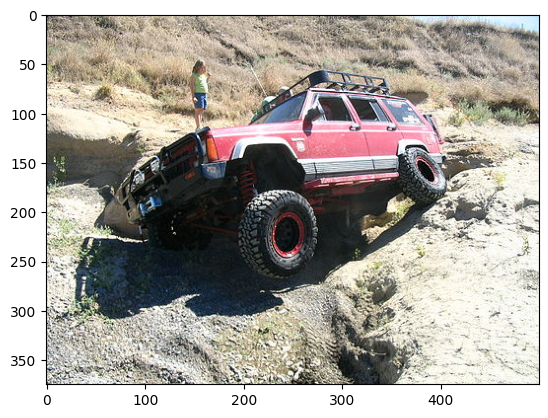

In [29]:
image_name = "36422830_55c844bc2d.jpg"
image_id = image_name.split('.')[0]
img_path = os.path.join(Base_dir, "Images", image_name)
image = Image.open(img_path)
plt.imshow(image)

In [9]:
data = pd.read_csv("./flickr8k/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


# 2- Image Feature Extraction

### Transfer Learning (VGG16)

![fjefj](https://storage.googleapis.com/lds-media/images/vgg16-architecture.width-1200.jpg)

In [10]:
model=VGG16()
model=Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

2025-12-25 00:56:18.009394: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-25 00:56:18.009605: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-25 00:56:18.009744: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

553467096/553467096 [==============================] - 151s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                          

2025-12-25 00:58:52.309283: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


### Storing the features

In [11]:
features={}
directory=os.path.join(Base_dir,'Images')
for img_name in tqdm(os.listdir(directory)):
    img_path=directory +'/'+ img_name
    image=load_img(img_path,target_size=(224,224))
    image=img_to_array(image)
    image=image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
    image=preprocess_input(image)
    feature=model.predict(image,verbose=0)
    image_id=img_name.split('.')[0]
    features[image_id]=feature

  0%|          | 0/8091 [00:00<?, ?it/s]

2025-12-25 00:59:09.810828: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


# 3-Text Preprocessing

### Opening the captions text file

In [12]:
with open(os.path.join(Base_dir,'captions.txt'),'r') as File:
    next(File)
    captions_file=File.read()

### Dictionary mapping image IDs to their captions

In [13]:
mapping = {}
for line in tqdm(captions_file.split('\n')):
    tokens = line.split(',')
    #Skips lines with fewer than 2 characters (likely blank lines)
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [14]:
def preprocessing(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i].lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

preprocessing(mapping)

# 4-Tokenization and Splitting 

In [15]:
#Used to extract all captions from the mapping dictionary into a single list
all_captions = [caption for key in mapping for caption in mapping[key]]


In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in all_captions)

# 5- Splitting data into train and test 

In [17]:
# Get the image IDs
image_ids = list(mapping.keys())

# Split into train and test sets (90% train, 10% test)
train, test = train_test_split(image_ids, test_size=0.1, random_state=42)

# 6. Data Generation (To Avoid Memory Issues) 

In [18]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [] , [] ,[] 
    n = 0
    while True:
        for key in data_keys:
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            n += 1
            if n == batch_size:
                yield {"image": np.array(X1), "text": np.array(X2)}, np.array(y)
                X1.clear()  # Clears the content of X1
                X2.clear()  # Clears the content of X2
                y.clear()   # Clears the content of y
                n = 0

# 7. Model Architecture 

In [19]:
# image feature layers
#4096 is the output of second last layer of the vgg16
inputs1=Input(shape=(4096,),name="image")
a=Dropout(0.3)(inputs1)
X=Dense(256,activation='relu')(a)

# sequence feature layers
inputs2=Input(shape=(max_length,),name="text")
c=Embedding(vocab_size,256)(inputs2)
d=Dropout(0.3)(c)
Y=LSTM(256)(d)



decoder1=add([X , Y])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

model=Model(inputs=[inputs1,inputs2],outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer='adam')

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None, 35)]                 0         []                            
                                                                                                  
 image (InputLayer)          [(None, 4096)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 35, 256)              2172160   ['text[0][0]']                
                                                                                                  
 dropout (Dropout)           (None, 4096)                 0         ['image[0][0]']               
                                                                                            

In [20]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    dpi=55,
    show_layer_activations=False,
    show_trainable=True
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# 8- Training the model 

In [21]:
epochs=12
batch_size=32
steps=len(train)//batch_size

for i in range(epochs):
    generator=data_generator(train,mapping,features,tokenizer,max_length,vocab_size,batch_size)
    model.fit(generator, epochs=1,steps_per_epoch=steps,verbose=1)

2025-12-25 01:10:17.846583: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ec584c65c10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-25 01:10:17.846626: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2025-12-25 01:10:17.853503: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1766605217.955046    7027 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


227/227 [==============================] - 135s 593ms/step - loss: 2.4078


# 9- Generate Captions for the Image 

In [22]:
def convert_to_word(number, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == number:
            return word
    return None


def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        y_pred = model.predict([image, sequence], verbose=0)
        y_pred = np.argmax(y_pred)
        word = convert_to_word(y_pred, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
      
    return in_text


In [23]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(Base_dir, "Images", image_name)
    image = Image.open(img_path)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print(y_pred)
    plt.imshow(image)

startseq man in blue shirt and hat is doing trick on his skateboard endseq


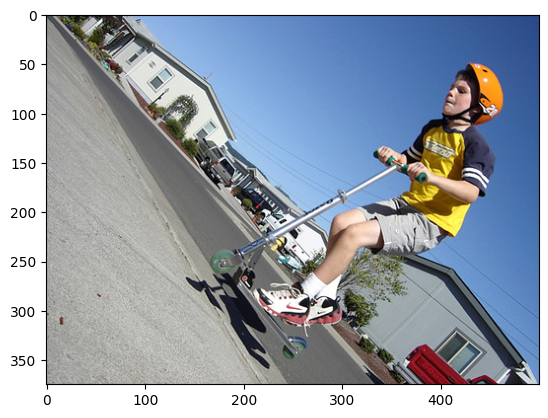

In [30]:
generate_caption("47870024_73a4481f7d.jpg")


# 10- BLEU Score 

In [28]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = [] , []

for key in tqdm(test):

    captions = mapping[key] 
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

    # calcuate BLEU score
#Unigram
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
#Bigram
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.555861
BLEU-2: 0.332453


# 11- Saving The model 

In [32]:
model.save('model.keras')


In [33]:
pickle.dump(tokenizer , open('tokenizer.pkl','wb'))

# 12- Text-To-Speech

In [34]:
!pip install gtts

  Attempting uninstall: click
    Found existing installation: click 8.3.1
    Uninstalling click-8.3.1:
      Successfully uninstalled click-8.3.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [gtts]━━━━━━ 1/2 [gtts]


In [35]:
# listen to predicted text
from gtts import gTTS
from IPython.display import Audio, display

In [36]:
caption_text = ' '.join(y_pred)

# Now, replace 'startseq' and 'endseq' and strip the caption
caption_text = caption_text.replace('startseq', '').replace('endseq', '').strip()
# Display the predicted caption
print("Predicted Caption:", caption_text)

# Step 1: Generate the audio for the caption using gTTS
tts = gTTS(caption_text, lang='en')
audio_path = "predicted_caption.mp3"
tts.save(audio_path)

# Step 2: Display the audio player before the image
print("Playing the predicted caption audio:")
display(Audio(audio_path, autoplay=True))

Predicted Caption: two dogs swimming in water
Playing the predicted caption audio:
